#### Import required libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
# import plotly.graph_objects as go


# from sklearn.ensemble import IsolationForest

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
import seaborn as sns #visualisation
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

#### Read the dataset
- integrate the data with normal and attack

In [5]:
# import data set from the local driver
# merges the two datasets into a single dataframe named 'df_concat', allowing for further analysis or processing of the combined data.

dff=pd.read_csv('drive/My Drive/Colab Notebooks/SWaT_Dataset_Normal_v0.csv')#, parse_dates = ['Timestamp'], index_col = 'Timestamp')
df=pd.read_csv('drive/My Drive/Colab Notebooks/SWaT_Dataset_Attack_v0 - Copy.csv')#, parse_dates = ['Timestamp'], index_col = 'Timestamp')
frames = [dff,df]
df_concat=pd.concat(frames)
df_concat.head(5)

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:00:00 PM,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
1,22/12/2015 4:00:01 PM,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,2.468587,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
2,22/12/2015 4:00:02 PM,2.439548,260.9131,2,2,1,244.3284,8.19008,306.101,2.467305,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
3,22/12/2015 4:00:03 PM,2.428338,260.2850,2,2,1,244.3284,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
4,22/12/2015 4:00:04 PM,2.424815,259.8925,2,2,1,244.4245,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal


#### Automatic Sensor data extraction  

In [6]:
# # select sensor data
df1=df_concat.filter(regex='(^Time|^PIT|^AIT|^FIT|^DPI|^LIT|^Norma)',axis=1)#.head()
df1.head()
df1.shape

(946719, 27)

In [7]:
# remove the space on Normal/Attack columns
df1['Normal/Attack'] = df1['Normal/Attack'].str.replace(' ', '')
#To see how the data is spread betwen Attack and Normal
print(df1.groupby('Normal/Attack')['Normal/Attack'].count())
# Rename the col name Normal/Attack with A
df1.rename(columns = {'Normal/Attack':'A'}, inplace = True)
df1.head(2)

Normal/Attack
Attack     54621
Normal    892098
Name: Normal/Attack, dtype: int64


<ipython-input-7-048a2842c303>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Normal/Attack'] = df1['Normal/Attack'].str.replace(' ', '')
<ipython-input-7-048a2842c303>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename(columns = {'Normal/Attack':'A'}, inplace = True)


,Timestamp,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
0,22/12/2015 4:00:00 PM,2.470294,261.5804,244.3284,8.19008,306.101,2.471278,20.79839,2.235275,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,Normal
1,22/12/2015 4:00:01 PM,2.457163,261.1879,244.3284,8.19008,306.101,2.468587,20.79839,2.234507,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,Normal


In [8]:
# Convert non-numeric to numeric

df1.A[df1.A== 'Normal'] = 0
df1.A[df1.A == 'Attack'] = 1
df1.head()

<ipython-input-8-c24e48151b45>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.A[df1.A== 'Normal'] = 0
<ipython-input-8-c24e48151b45>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.A[df1.A== 'Normal'] = 0
<ipython-input-8-c24e48151b45>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.A[df1.A == 'Attack'] = 1
<ipython-input-8-c24e48151b45>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

,Timestamp,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
0,22/12/2015 4:00:00 PM,2.470294,261.5804,244.3284,8.19008,306.101,2.471278,20.79839,2.235275,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0
1,22/12/2015 4:00:01 PM,2.457163,261.1879,244.3284,8.19008,306.101,2.468587,20.79839,2.234507,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0
2,22/12/2015 4:00:02 PM,2.439548,260.9131,244.3284,8.19008,306.101,2.467305,20.84320,2.233354,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0
3,22/12/2015 4:00:03 PM,2.428338,260.2850,244.3284,8.19008,306.101,2.466536,20.84320,2.233354,327.2799,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0
4,22/12/2015 4:00:04 PM,2.424815,259.8925,244.4245,8.19008,306.101,2.466536,20.84320,2.233354,327.1597,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0


In [9]:
# convert the data type to float
df1['A'] = df1['A'].astype('float')

<ipython-input-9-e14d35a4be6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['A'] = df1['A'].astype('float')


In [10]:
# make the Timestamp to datetime datatype
df1['Timestamp'] = pd.to_datetime(df1['Timestamp']) # conveting the date time stamp to the timestamp series
df1.head()
# # df1.shape

#df1['Timestamp'] = pd.to_datetime(df1['Timestamp'])

#df1.head()

<ipython-input-10-5fd3e043a7d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Timestamp'] = pd.to_datetime(df1['Timestamp']) # conveting the date time stamp to the timestamp series


,Timestamp,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
0,2015-12-22 16:00:00,2.470294,261.5804,244.3284,8.19008,306.101,2.471278,20.79839,2.235275,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
1,2015-12-22 16:00:01,2.457163,261.1879,244.3284,8.19008,306.101,2.468587,20.79839,2.234507,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2,2015-12-22 16:00:02,2.439548,260.9131,244.3284,8.19008,306.101,2.467305,20.84320,2.233354,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
3,2015-12-22 16:00:03,2.428338,260.2850,244.3284,8.19008,306.101,2.466536,20.84320,2.233354,327.2799,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
4,2015-12-22 16:00:04,2.424815,259.8925,244.4245,8.19008,306.101,2.466536,20.84320,2.233354,327.1597,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0


In [11]:
# make Timestamp feature  as index
df1= df1.set_index('Timestamp')
df1.head(2)

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,2.470294,261.5804,244.3284,8.19008,306.101,2.471278,20.79839,2.235275,327.4401,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:01,2.457163,261.1879,244.3284,8.19008,306.101,2.468587,20.79839,2.234507,327.4401,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0


##### Interpolation the data with each time stamp

In [12]:
# resample the data with 5 second
df1=df1.resample('15s').mean()
df1.interpolate(method='polynomial',order=2)
df1.head(2)

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,2.533111,261.015140,244.618893,8.190080,306.08562,2.469621,20.827837,2.234319,326.924740,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.029480,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:15,2.520919,261.685047,245.311033,8.191511,305.80878,2.473363,20.795186,2.235198,328.529547,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.042297,0.0,4.277749,0.000256,0.0


In [13]:
# Count NaN values of whole DataFrame
nan_count = df1.isna().sum()#.sum()
#print(nan_count )

In [14]:
df1.fillna(method = 'ffill', inplace = True)

In [15]:
df1.shape

(235920, 26)

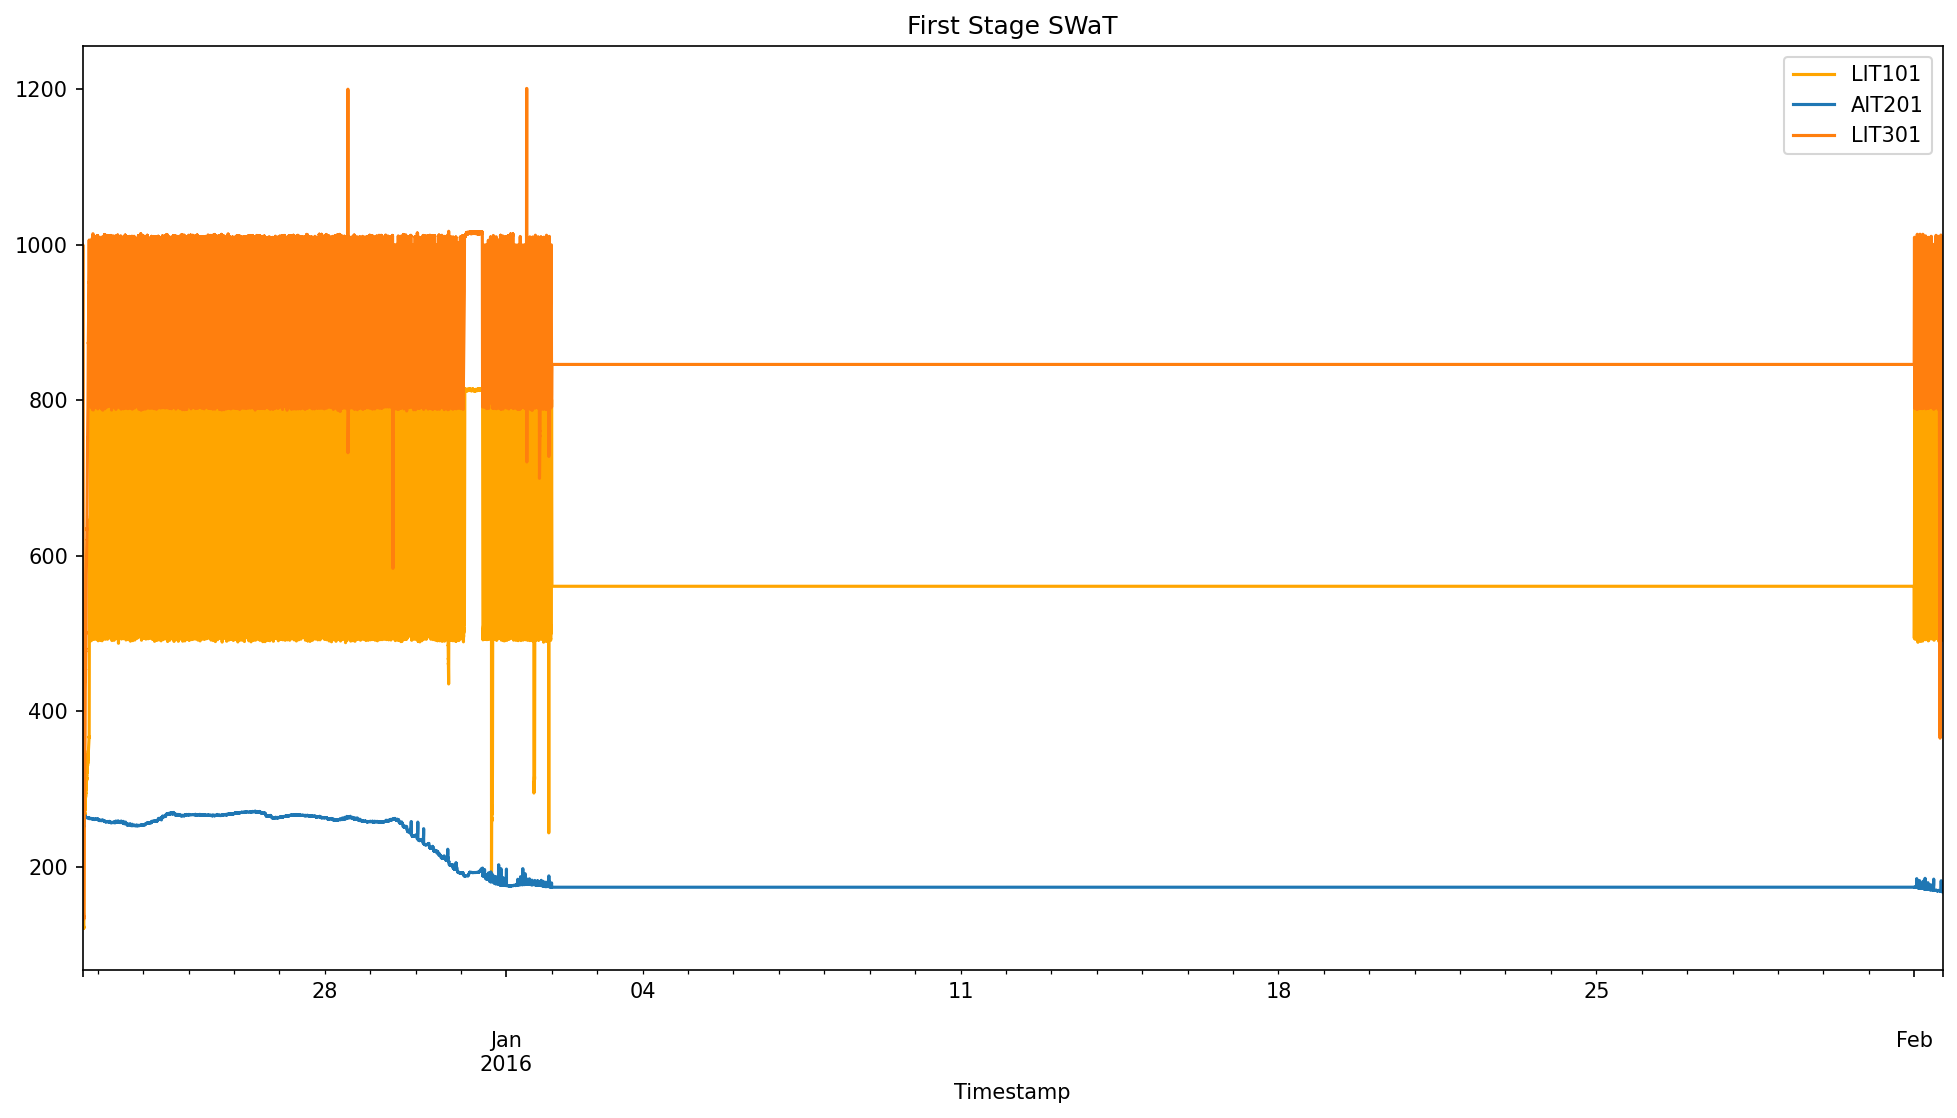

In [16]:
# code
# Visualizing The first stage with respect to time series

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)

# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
#df1['FIT101'].plot(label='FIT101')
df1['LIT101'].plot(label='LIT101', color='orange')
df1['AIT201'].plot(label='AIT201')

df1['LIT301'].plot(label='LIT301')

# adding title to the plot
plt.title('First Stage SWaT')
# adding Label to the x-axis
plt.xlabel('Timestamp')
# adding legend to the curve
plt.legend()

In [17]:
# df1= df1.drop('Timestamp', axis=1)

In [18]:
# make the class label into 2 since during sampling and interpolation it create the new class labels
df1.loc[df1['A'] >= 0.2, 'lablel'] = 1
df1.loc[df1['A'] ==0.0, 'lablel'] = 0

In [19]:
df1.head(2)

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A,lablel
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,2.533111,261.015140,244.618893,8.190080,306.08562,2.469621,20.827837,2.234319,326.924740,0.0,...,0.001666,0.001409,0.001664,0.0,10.029480,0.0,4.277749,0.000256,0.0,0.0
2015-12-22 16:00:15,2.520919,261.685047,245.311033,8.191511,305.80878,2.473363,20.795186,2.235198,328.529547,0.0,...,0.001666,0.001409,0.001664,0.0,10.042297,0.0,4.277749,0.000256,0.0,0.0


In [20]:
# fill the missing values with forward and backward of the cols

df1=df1.fillna(method="ffill")

In [21]:
df1.isna().sum()

FIT101     0
LIT101     0
AIT201     0
AIT202     0
AIT203     0
FIT201     0
DPIT301    0
FIT301     0
LIT301     0
AIT401     0
AIT402     0
FIT401     0
LIT401     0
AIT501     0
AIT502     0
AIT503     0
AIT504     0
FIT501     0
FIT502     0
FIT503     0
FIT504     0
PIT501     0
PIT502     0
PIT503     0
FIT601     0
A          0
lablel     0
dtype: int64

#### Visualize the dataset
-  Plotting the number of normal and Attack transactions in the dataset.

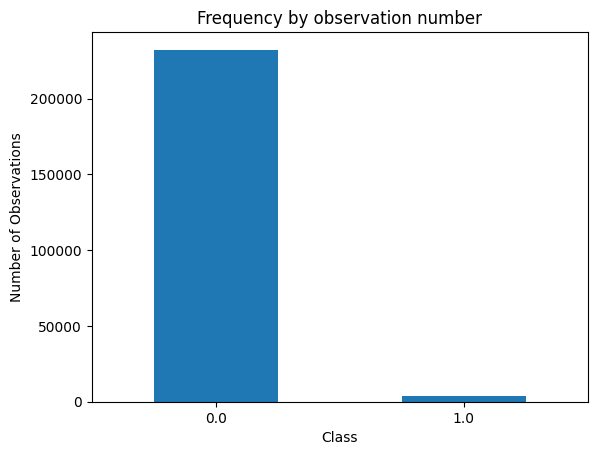

In [22]:
#Visualizing the imbalanced dataset
count_classes = pd.value_counts(df1['lablel'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(len(df1['lablel'].unique())))#, df1.A.unique()))
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [23]:
df1= df1.drop('A', axis=1)

In [24]:
# count the number of anomalies and normal data points in our dataset
df1['lablel'].value_counts()


0.0    232245
1.0      3675
Name: lablel, dtype: int64

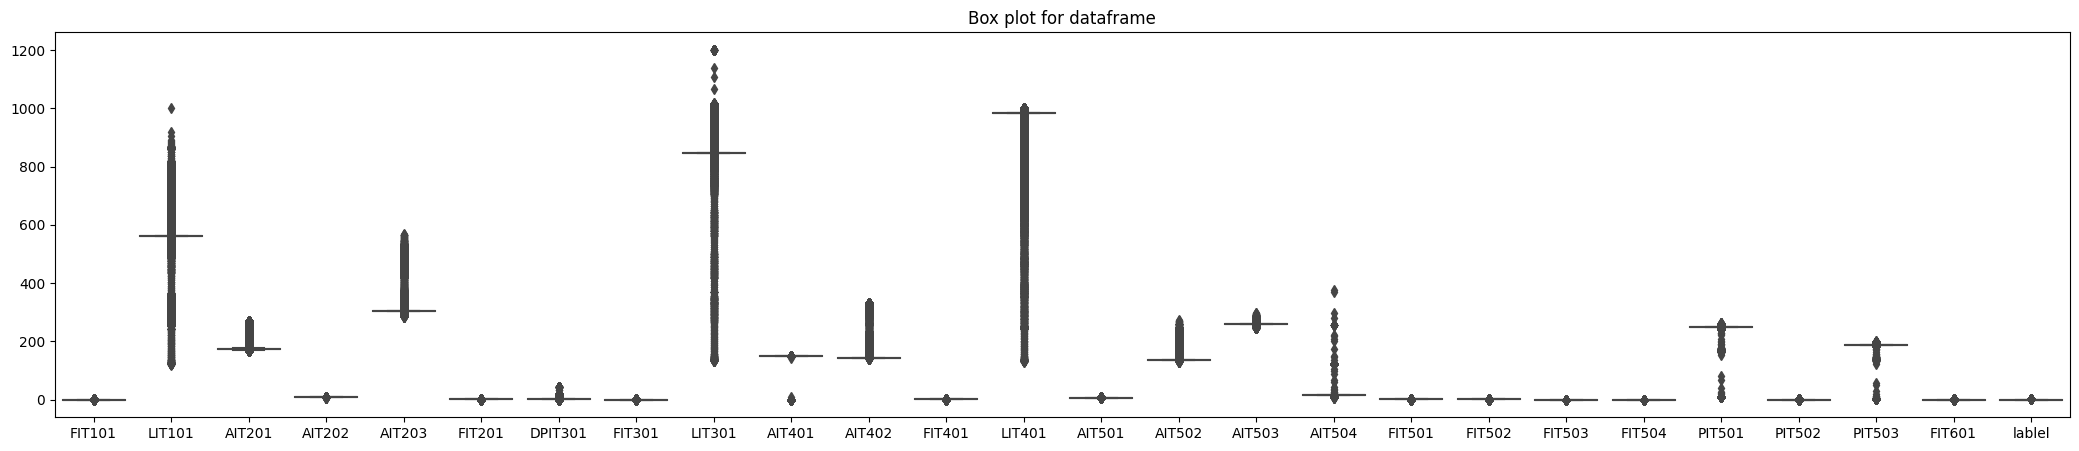

In [25]:
# checking the outlier in the data
# sns.boxplot(data=df)
fig = plt.figure(figsize=(26,5))
sns.boxplot(data=df1)
# plt.xticks([1,2],['Our data', 'Hypothetical data'])
# plt.ylabel('Grade')
plt.title('Box plot for dataframe')
plt.show()

In [26]:
from imblearn.over_sampling import SMOTE

# Assuming df is your DataFrame with features and target variable
X = df1.drop('lablel', axis=1)
y = df1['lablel']

# Create SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE to the data
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new balanced DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
df_resampled.head()

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,lablel
0,2.533111,261.015140,244.618893,8.190080,306.085620,2.469621,20.827837,2.234319,326.924740,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.029480,0.0,4.277749,0.000256,0.0
1,2.520919,261.685047,245.311033,8.191511,305.808780,2.473363,20.795186,2.235198,328.529547,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.042297,0.0,4.277749,0.000256,0.0
2,2.584334,262.470107,245.753213,8.194352,305.745540,2.470492,20.739483,2.232841,329.076960,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.047638,0.0,4.277749,0.000256,0.0
3,2.483639,260.852907,246.355653,8.195527,305.595167,2.470603,20.785367,2.233524,328.673740,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.029480,0.0,4.277749,0.000256,0.0
4,2.598576,261.410287,247.000760,8.196061,305.511400,2.469014,20.721558,2.233166,328.489493,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.029480,0.0,4.277749,0.000256,0.0


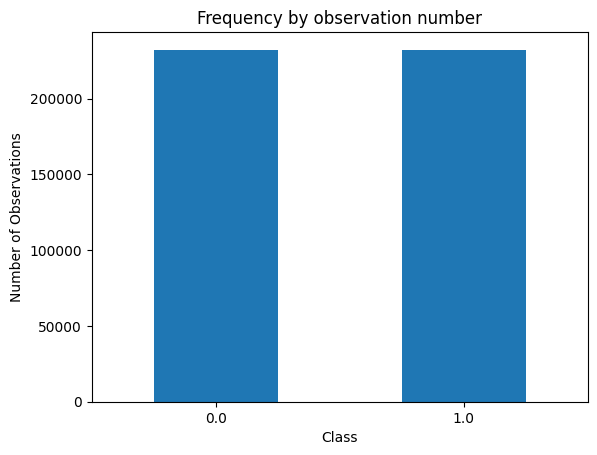

In [27]:
#Visualizing the balanced dataset
count_classes2 = pd.value_counts(df_resampled['lablel'], sort = True)
count_classes2.plot(kind = 'bar', rot=0)
plt.xticks(range(len(df_resampled['lablel'].unique())))#, df1.A.unique()))
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [28]:
df1=df_resampled

### Normalize using Min max Scaler

In [29]:
# # For content length, use the Min max Scalar.
# from sklearn.preprocessing import MinMaxScaler

con_feats = ['FIT101','LIT101','AIT201','AIT202','AIT203','FIT201','DPIT301','FIT301','FIT301','LIT301','AIT401',
            'AIT402','FIT401','LIT401','AIT501','AIT502','AIT503','AIT504','FIT501','FIT502','FIT503','FIT504',
            'PIT501','PIT502','PIT503','FIT601']
scaler = MinMaxScaler()
df1[con_feats] = scaler.fit_transform(df1[con_feats])
df1.head(5)

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,lablel
0,0.951059,0.159306,0.736493,0.733426,0.073465,0.874556,0.462698,0.957272,0.181522,0.0,...,0.014168,0.00073,0.000635,0.002186,0.0,0.004448,0.0,0.005922,0.000143,0.0
1,0.946482,0.160068,0.743149,0.733906,0.072483,0.875881,0.461972,0.957649,0.183025,0.0,...,0.014168,0.00073,0.000635,0.002186,0.0,0.004498,0.0,0.005922,0.000143,0.0
2,0.970291,0.160961,0.747401,0.734857,0.072259,0.874864,0.460734,0.956639,0.183537,0.0,...,0.014168,0.00073,0.000635,0.002186,0.0,0.004519,0.0,0.005922,0.000143,0.0
3,0.932485,0.159122,0.753195,0.735250,0.071725,0.874904,0.461754,0.956931,0.183160,0.0,...,0.014168,0.00073,0.000635,0.002186,0.0,0.004448,0.0,0.005922,0.000143,0.0
4,0.975638,0.159756,0.759399,0.735429,0.071428,0.874341,0.460336,0.956778,0.182987,0.0,...,0.014168,0.00073,0.000635,0.002186,0.0,0.004448,0.0,0.005922,0.000143,0.0


In [83]:
df1.shape

(464490, 26)

####   Split the Data to train and Test

In [31]:
# split the normal data with respect to test and Train
from sklearn.model_selection import train_test_split
x_good_train, x_good_test = train_test_split(df1, test_size=0.2, random_state=42)

In [32]:
print(x_good_train.shape)
print(x_good_test.shape)

(371592, 26)
(92898, 26)


In [33]:
# Training and testing with removing the class
x_good_train = x_good_train[x_good_train.lablel == 0.0] #where normal transactions
x_good_train = x_good_train.drop(['lablel'], axis=1) #drop the class columns

test_y = x_good_test['lablel'] # save the class column for the test set
x_good_test = x_good_test.drop(['lablel'], axis=1) #drop the class column

x_good_train = x_good_train.values #transform to ndarray
x_good_test = x_good_test.values
x_good_train.shape, x_good_test.shape #,x_good_train.shape,test_y.shape

((185902, 25), (92898, 25))

#### Build Model

In [34]:
#########
#Define the autoencoder model
#Since we're dealing with numeric values we can use only Dense layers.

from sklearn import metrics
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Input, Dense
from keras import regularizers
from keras.models import Model, load_model
import datetime

In [35]:
#TIME_STEPS = 288
model = Sequential()
# encoder
model.add(Dense(25, input_dim=x_good_train.shape[1], activation='sigmoid')) # Input layers or encoder sigmoid relu
Dropout(0.01),
model.add(Dense(64, activation='sigmoid')) ##
Dropout(0.01),
model.add(Dense(64, activation='sigmoid')) ##
Dropout(0.01),

# model.add(Dense(128, activation='relu')) ## decoder
# Dropout(0.1),
model.add(Dense(x_good_train.shape[1])) # output layers
model.compile(loss='msle',metrics=['accuracy'],optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                650       
                                                                 
 dense_1 (Dense)             (None, 64)                1664      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 25)                1625      
                                                                 
Total params: 8,099
Trainable params: 8,099
Non-trainable params: 0
_________________________________________________________________


### Train the model
Please note that we are using x_good_test as both the input and the target since this is a reconstruction model.

In [36]:
#model.fit(x_good_train,x_good_train,verbose=1,epochs=100)
grid=model.fit(
    x_good_train,x_good_train,
    verbose=2,
    epochs=30,
    batch_size=32,
    validation_data=(x_good_test, x_good_test),
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ])
score=model.evaluate(x_good_test, x_good_test, verbose=1)
print('Test loss:', score[0])
print('accuracy:', score[1])

Epoch 1/30
5810/5810 - 17s - loss: 0.1048 - accuracy: 6.7240e-04 - val_loss: 0.1180 - val_accuracy: 5.8128e-04 - 17s/epoch - 3ms/step
Epoch 2/30
5810/5810 - 13s - loss: 0.1030 - accuracy: 6.1323e-04 - val_loss: 0.0986 - val_accuracy: 5.3822e-04 - 13s/epoch - 2ms/step
Epoch 3/30
5810/5810 - 14s - loss: 0.1030 - accuracy: 9.6287e-04 - val_loss: 0.0981 - val_accuracy: 7.3199e-04 - 14s/epoch - 2ms/step
Epoch 4/30
5810/5810 - 14s - loss: 0.1030 - accuracy: 0.0013 - val_loss: 0.0971 - val_accuracy: 8.3963e-04 - 14s/epoch - 2ms/step
Epoch 5/30
5810/5810 - 14s - loss: 0.0703 - accuracy: 0.0066 - val_loss: 0.0716 - val_accuracy: 0.0034 - 14s/epoch - 2ms/step
Epoch 6/30
5810/5810 - 19s - loss: 0.0658 - accuracy: 0.0116 - val_loss: 0.0713 - val_accuracy: 0.0089 - 19s/epoch - 3ms/step
Epoch 7/30
5810/5810 - 15s - loss: 0.0658 - accuracy: 0.0152 - val_loss: 0.0713 - val_accuracy: 0.0083 - 15s/epoch - 3ms/step
Epoch 8/30
5810/5810 - 16s - loss: 0.0658 - accuracy: 0.0161 - val_loss: 0.0710 - val_accu

#### Plot training and test loss

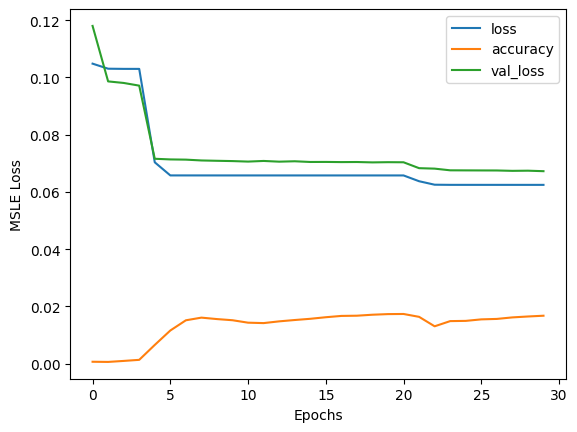

In [37]:
plt.plot(grid.history['loss'])
plt.plot(grid.history['accuracy'])
plt.plot(grid.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss','accuracy', 'val_loss'])
plt.show()

### Detect Anomalies on test data  
- Anomalies are data points where the reconstruction loss is higher
- To calculate the reconstruction loss on test data, predict the test data and calculate the mean square error between the test data and the reconstructed test data.

#### Predictions and Computing Reconstruction Error

In [38]:
test_x_predictions = model.predict(x_good_test)#,verbose=1)
mse = np.mean(np.power(x_good_test - test_x_predictions,2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,'A': test_y}, index=test_y.index)
error_df.head()

2904/2904 [==============================] - 4s 1ms/step


,Reconstruction_error,A
169858,0.318359,0.0
603,0.310217,0.0
13630,0.389897,0.0
89395,0.318359,0.0
85835,0.318359,0.0


In [39]:
# find the maximum of each column using reconstruction error
maxValues = error_df.max()

print(maxValues)

Reconstruction_error    0.590413
A                       1.000000
dtype: float64


In [40]:
# finding the number of anomalies using highest reconstruction Error

outliers = error_df.index[error_df.Reconstruction_error >0.3].tolist()
number_of_outliers = len(outliers)
print("Number of elements in the anomalies: ", number_of_outliers)

Number of elements in the anomalies:  92193


In [41]:
# To identify the maximum and minimum data point for identifying bins
import tensorflow as tf
# reconstruction loss for normal test data
#reconstructions = model.predict(normal_test_data)
train_loss1 = tf.keras.losses.mse(test_x_predictions, x_good_test)


trainloss1=pd.DataFrame(train_loss1)
#trainloss.describe()
#trainloss.to_csv(r'/home/jovyan/trainloss.csv',index=False)
trainloss1.describe()


,0
count,92898.000000
mean,0.391101
std,0.080725
min,0.158356
25%,0.318359
50%,0.364849
75%,0.486377
max,0.590413


Text(0.5, 1.0, 'bins - loss distribution = 23')

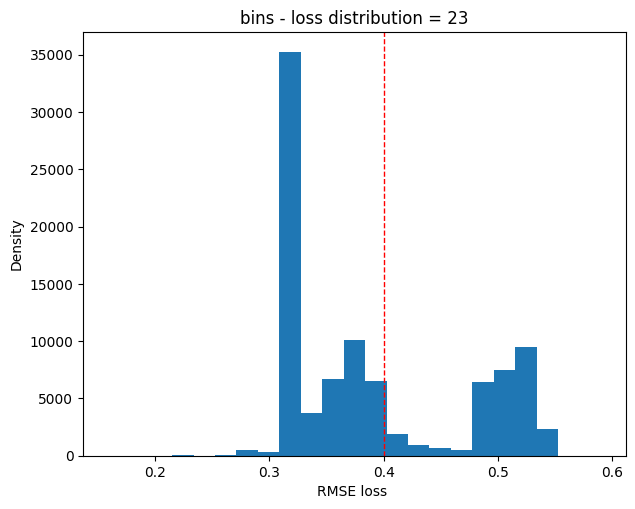

In [58]:
# rules-of-thumb to identify the number of bins Freedman–Diaconis rule
trainloss1=pd.DataFrame(trainloss1)
q1 = trainloss1.quantile(0)
q3 = trainloss1.quantile(1)
iqr = q3 - q1
bin_width = (2 * iqr) / (len(trainloss1) ** (1 / 3))
bin_count = int(np.ceil((trainloss1.max() - trainloss1.min()) / bin_width))
fig = plt.figure(figsize=(7,5.5))
plt.hist(train_loss1, bins = bin_count)

plt.axvline(0.4,0, 9000,color='red', linestyle='dashed', linewidth=1)
plt.xlabel('RMSE loss ')
plt.ylabel('Density')
plt.title(f'bins - loss distribution = {bin_count}')

### Model Interpretability

In [59]:
# change X_tes_scaled to pandas dataframe
data_n = pd.DataFrame(x_good_test, index= test_y.index)#, columns=numerical_cols)


In [60]:
def compute_error_per_dim(point):

    initial_pt = np.array(data_n.loc[point,:]).reshape(1,9)
    reconstrcuted_pt = model.predict(initial_pt)

    return abs(np.array(initial_pt - reconstrcuted_pt)[0])

In [61]:
outliers = error_df.index[error_df.Reconstruction_error > 0.4].tolist()
number_of_outliers = len(outliers)
print("Number of elements in the anomalies: ", number_of_outliers)

Number of elements in the anomalies:  30082


Text(0.5, 0, 'Data point index')

<Figure size 1800x1000 with 0 Axes>

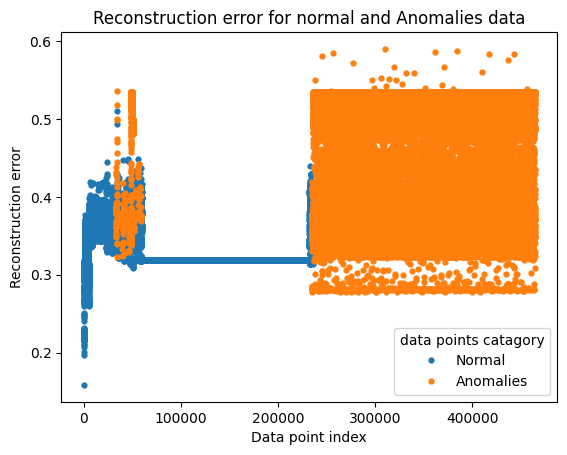

In [62]:
# visualize the anomaly points in the dataset with 2D
plt.figure(figsize=(18,10))
threshold_fixed = 0.5
groups = error_df.groupby('A')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Anomalies" if name == 1 else "Normal")
ax.legend(title='data points catagory')
plt.title("Reconstruction error for normal and Anomalies data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

#plt.savefig('SWaT_AE_5sed.png')

#### Calculate RMSE and MAE

In [63]:
# Define a function to calculate MAE and RMSE
errors = test_x_predictions - x_good_test
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()

print('The performance  of autoencoder'+ ':')
print('')
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Mean Square Error:{:.4f}' .format(mse))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('')

The performance  of autoencoder:

Mean Absolute Error: 0.3445
Mean Square Error:0.3911
Root Mean Square Error: 0.6254



In [64]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
threshold_fixed = 0.4
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.A, pred_y)
plt.figure(figsize=(4, 4))

print(conf_matrix)
# sns.heatmap(conf_matrix, xticklabels=df1.A, yticklabels=df1.A, annot=True, fmt="d");
# plt.title("Confusion matrix")
# plt.ylabel('True class')
# plt.xlabel('Predicted class')
# plt.show()



# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['A'], error_df['pred']))
print(" Recall: ",recall_score(error_df['A'], error_df['pred']))
print(" Precision: ",precision_score(error_df['A'], error_df['pred']))
print(classification_report(error_df['A'], error_df['pred']))

[[45789   554]
 [17027 29528]]
 Accuracy:  0.8107494240995501
 Recall:  0.6342605520352271
 Precision:  0.9815836712984509
              precision    recall  f1-score   support

         0.0       0.73      0.99      0.84     46343
         1.0       0.98      0.63      0.77     46555

    accuracy                           0.81     92898
   macro avg       0.86      0.81      0.80     92898
weighted avg       0.86      0.81      0.80     92898



<Figure size 400x400 with 0 Axes>

In [86]:
# !pip install shap



### Explainable AI (XAI) for autoencoder model

Permutation explainer: 1001it [00:39, 18.89it/s]                          
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


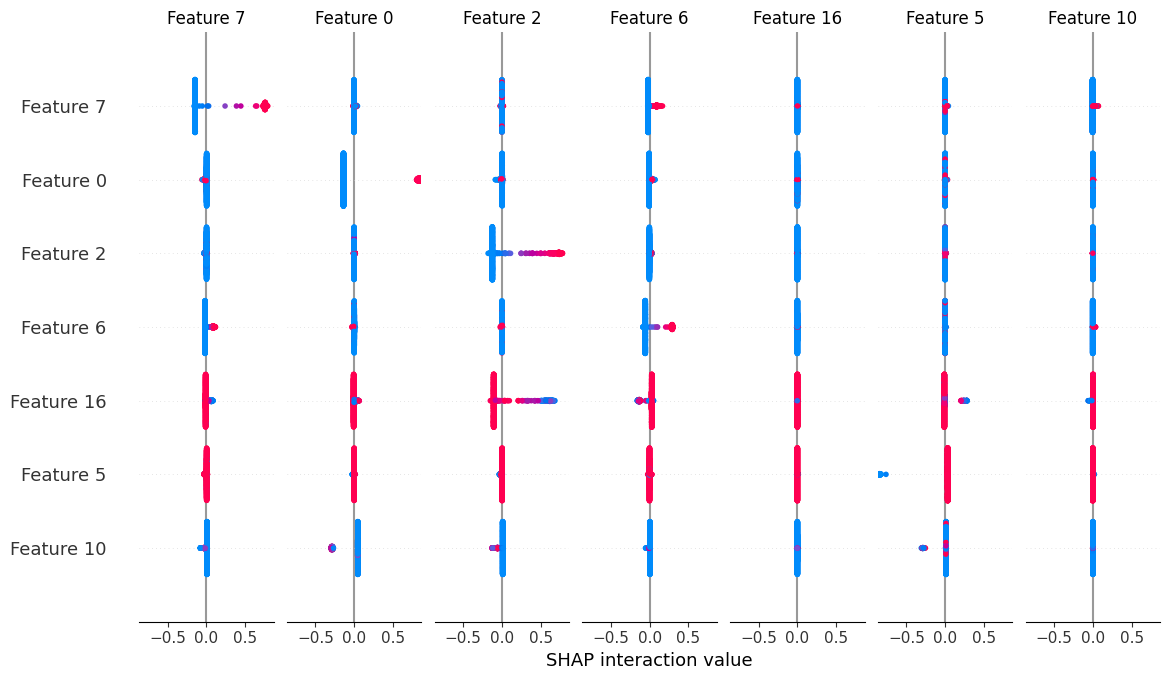

In [85]:
import shap
# Create an explainer object x_good_train
explainer = shap.Explainer(model, x_good_train)

# Calculate SHAP values for a subset of data
shap_values = explainer.shap_values(x_good_train[:1000])

# Visualize the SHAP values
shap.summary_plot(shap_values, x_good_train[:1000], plot_type="bar")


#### Mean p-Powered Error for auto encoder
- To enhance the perfomance of reall and precision

In [65]:
test_x_predictions2 = model.predict(x_good_test)#,verbose=1)
mse = np.mean(np.power(x_good_test - test_x_predictions2, 4), axis=1)
error_df_mean_power = pd.DataFrame({'Reconstruction_error': mse,'A': test_y}, index=test_y.index)
error_df_mean_power.head()

2904/2904 [==============================] - 4s 1ms/step


,Reconstruction_error,A
169858,0.526234,0.0
603,0.563369,0.0
13630,0.745192,0.0
89395,0.526234,0.0
85835,0.526234,0.0


In [66]:
# To identify the maximum and minimum data point for identifying bins
import tensorflow as tf
# reconstruction loss for normal test data
#reconstructions = model.predict(normal_test_data)
train_loss2 = tf.keras.losses.mse(test_x_predictions2, x_good_test)


train_loss2=pd.DataFrame(train_loss2)
#trainloss.describe()
#trainloss.to_csv(r'/home/jovyan/trainloss.csv',index=False)
train_loss2.describe()


,0
count,92898.000000
mean,0.391101
std,0.080725
min,0.158356
25%,0.318359
50%,0.364849
75%,0.486377
max,0.590413


In [67]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
threshold_fixed = 0.48
pred_y = [1 if e > threshold_fixed else 0 for e in error_df_mean_power.Reconstruction_error.values]
error_df_mean_power['pred'] =pred_y
conf_matrix = confusion_matrix(error_df_mean_power.A, pred_y)
plt.figure(figsize=(4, 4))

print(conf_matrix)
# sns.heatmap(conf_matrix, xticklabels=df1.A, yticklabels=df1.A, annot=True, fmt="d");
# plt.title("Confusion matrix")
# plt.ylabel('True class')
# plt.xlabel('Predicted class')
# plt.show()

# print classification report
#print(classification_report(error_df.A, pred_y)

# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df_mean_power['A'], error_df_mean_power['pred']))
print(" Recall: ",recall_score(error_df_mean_power['A'], error_df_mean_power['pred']))
print(" Precision: ",precision_score(error_df_mean_power['A'], error_df_mean_power['pred']))
# print classification report
print(classification_report(error_df_mean_power['A'], error_df_mean_power['pred']))

[[  130 46213]
 [  800 45755]]
 Accuracy:  0.49392882516308206
 Recall:  0.9828160240575663
 Precision:  0.4975100034794711
              precision    recall  f1-score   support

         0.0       0.14      0.00      0.01     46343
         1.0       0.50      0.98      0.66     46555

    accuracy                           0.49     92898
   macro avg       0.32      0.49      0.33     92898
weighted avg       0.32      0.49      0.33     92898



<Figure size 400x400 with 0 Axes>